# Twitter Sentiment Analysis with BERT and roBERTa Transformers

In [5]:
# traverse files in /kaggle/input
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [7]:
# custom confusion matrix
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [8]:
# load train and test data into dataframes
import pandas as pd
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

In [9]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [11]:
# convert TweetAt column to pandas datetime format
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

In [12]:
# remove duplicate tweets
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


In [14]:
# count tweets per day
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

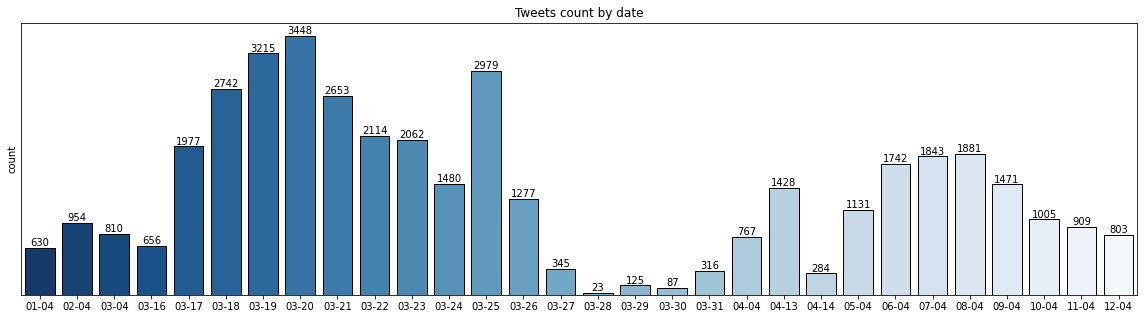

In [15]:
# plot tweets per day count
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [16]:
# count tweets per country
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

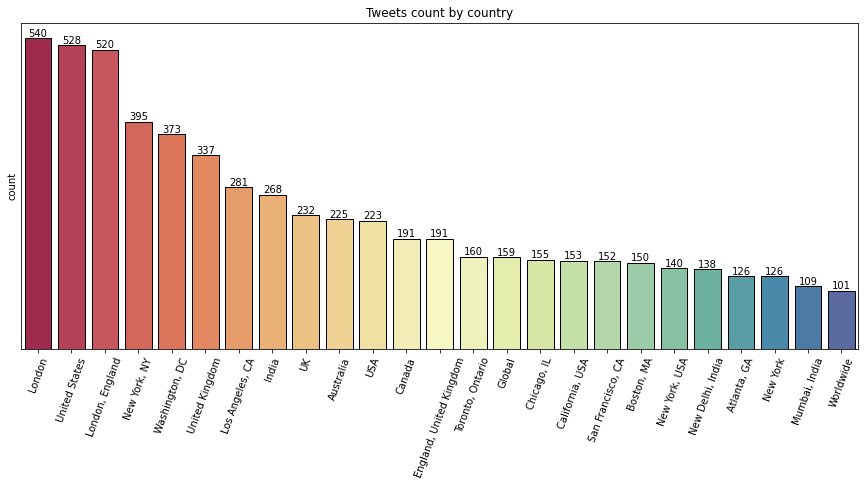

In [17]:
# plot tweets per country count
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [18]:
# data cleaning -> just keep columns OriginalTweet (raw tweet) and target Sentiment
df = df[['OriginalTweet','Sentiment']]

In [19]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [20]:
# data cleaning -> custom functions to clean tweets content

import re, string, emoji, nltk

# remove emojis
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

# remove punctuations, links, mentions, new line characters, non utf8/ascii
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# remove hashtags at the end of the sentence
# keep hashtags in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

# remove special characters such as &, $
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [21]:
# apply tweet content cleaning functions to training data
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [22]:
# apply tweet content cleaning functions to testing data
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [23]:
# new column (attribute) for cleaned tweets
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [24]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [25]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [26]:
# compute tweet text length (to check if we removed too much of original tweet)
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [27]:
df['text_len'] = text_len

In [28]:
# compute tweet text length (to check if we removed too much of original tweet)
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [29]:
df_test['text_len'] = text_len_test

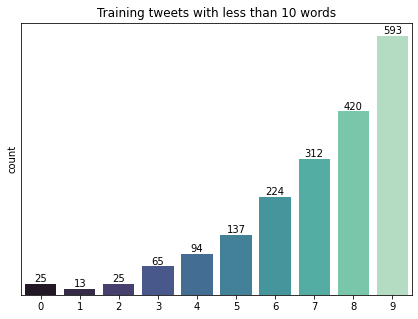

In [30]:
# plot count of training tweets with less than 10 words
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

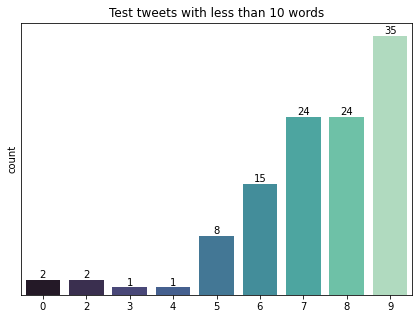

In [31]:
# plot count of testing tweets with less than 10 words
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [32]:
# filter training tweets with length <= 4
df = df[df['text_len'] > 4]

In [33]:
# filter testing tweets with length <= 4
df_test = df_test[df_test['text_len'] > 4]

In [34]:
# tokenizer to split text into tokens that BERT can process
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
# take tweet texts in training data and encode them in tokenizer one at a time -> compute length and store it
# find max token length
import numpy as np
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [36]:
# check training tweets tokenizes with more than 80 tokens
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

These sentences are not in english. They should be dropped.

In [37]:
df['token_lens'] = token_lens

In [38]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [39]:
df = df.sample(frac=1).reset_index(drop=True)

In [40]:
# take tweet texts in testing data and encode them in tokenizer one at a time -> compute length and store it
# find max token length
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [41]:
# check testing tweets tokenizes with more than 80 tokens
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [42]:
df_test['token_lens'] = token_lens_test

In [43]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [44]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [45]:
# count number of positive, negative, neutral, etc tweets
df['Sentiment'].value_counts()

Positive              11382
Negative               9890
Neutral                7567
Extremely Positive     6618
Extremely Negative     5478
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [46]:
# encode categories with numbers (just three categories) on training data
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [47]:
# encode categories with numbers (just three categories) on testing data
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [48]:
df['Sentiment'].value_counts()

2    18000
0    15368
1     7567
Name: Sentiment, dtype: int64

In [49]:
# since the classes are imbalanced -> oversample train test to remove bias towards majority class
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [50]:
train_os['Sentiment'].value_counts()

2    18000
0    18000
1    18000
Name: Sentiment, dtype: int64

In [51]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [52]:
# validation set extracted from training set to prevent overfitting
from sklearn.model_selection import train_test_split
seed=43
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [53]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [54]:
# save a copy of label encoded Sentiment
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [55]:
# use one-hot encoding for Sentiment (same as dummies)
from sklearn import preprocessing
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# MODEL 0: NAIVE BAYES CLASSIFIER

In [56]:
# tokenize tweets
from sklearn.feature_extraction.text import CountVectorizer
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [57]:
# TF-IDF to evaluate importance of a word
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [58]:
# define Naive Bayes Classifier model
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()

In [59]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [60]:
nb_pred = nb_clf.predict(X_test_tf)

In [61]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
print('\tClassification Report for Naive Bayes\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes

               precision    recall  f1-score   support

    Negative       0.71      0.78      0.74      1632
     Neutral       0.60      0.45      0.51       615
    Positive       0.73      0.73      0.73      1545

    accuracy                           0.71      3792
   macro avg       0.68      0.65      0.66      3792
weighted avg       0.70      0.71      0.70      3792



# MODEL 1: BERT

In [62]:
# custom tokenize function to generate tokens that BERT can process
MAX_LEN=128 # max length of tokenizes sequences (max number of tokens given to BERT)
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [63]:
# tokenize train, validation, test datasets
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [64]:
# define BERT model
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [65]:
# function to host pre-trained BERT model and attach it to a 3 neurons output layer,
# necessary to perform the classification of the 3 classes (emotions) of the dataset
import tensorflow as tf
from tensorflow import keras
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [66]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            2307        tf_bert_model[0][1]          

In [67]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 753s 486ms/step - loss: 0.5500 - categorical_accuracy: 0.7825 - val_loss: 0.3503 - val_categorical_accuracy: 0.8735
Epoch 2/4
1519/1519 [==============================] - 735s 484ms/step - loss: 0.2921 - categorical_accuracy: 0.8979 - val_loss: 0.2484 - val_categorical_accuracy: 0.9069
Epoch 3/4
1519/1519 [==============================] - 735s 484ms/step - loss: 0.1971 - categorical_accuracy: 0.9313 - val_loss: 0.2198 - val_categorical_accuracy: 0.9217
Epoch 4/4
1519/1519 [==============================] - 736s 484ms/step - loss: 0.1339 - categorical_accuracy: 0.9542 - val_loss: 0.2257 - val_categorical_accuracy: 0.9302


In [68]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [69]:
# convert model's predicted probability distributions (result_bert)
# into one-hot encoded labels, where each row represents a single sample
# and contains a 1 in the column of the predicted class and 0s elsewhere
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

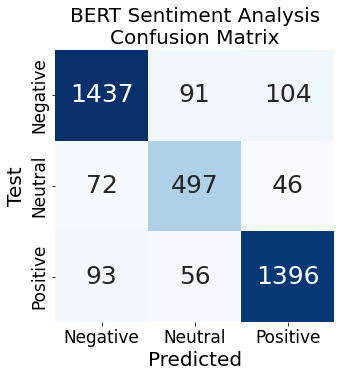

In [70]:
# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [71]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      1632
     Neutral       0.77      0.81      0.79       615
    Positive       0.90      0.90      0.90      1545

   micro avg       0.88      0.88      0.88      3792
   macro avg       0.86      0.86      0.86      3792
weighted avg       0.88      0.88      0.88      3792
 samples avg       0.88      0.88      0.88      3792



# MODEL 2: roBERTa

In [72]:
# tokenizer to split text into tokens that roBERTa can process
from transformers import RobertaTokenizerFast
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [73]:
# check length of longest tokenized sentence
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

107

In [75]:
# custom tokenize function to generate tokens that roBERTa can process
MAX_LEN=128 # max length of tokenizes sequences (max number of tokens given to roBERTa)
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [76]:
# tokenize train, validation, test datasets
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [82]:
# function to host pre-trained roBERTa model and attach it to a 3 neurons output layer,
# necessary to perform the classification of the 3 classes (emotions) of the dataset
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [83]:
# define roBERTa model
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [84]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo TFBaseModelOutputWit 124645632   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            2307        tf_roberta_model_1[0][1]   

In [85]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
1620/1620 [==============================] - 747s 455ms/step - loss: 0.5737 - categorical_accuracy: 0.7743 - val_loss: 0.4065 - val_categorical_accuracy: 0.8559
Epoch 2/4
1620/1620 [==============================] - 736s 454ms/step - loss: 0.3345 - categorical_accuracy: 0.8810 - val_loss: 0.2974 - val_categorical_accuracy: 0.8907
Epoch 3/4
1620/1620 [==============================] - 736s 454ms/step - loss: 0.2472 - categorical_accuracy: 0.9114 - val_loss: 0.2742 - val_categorical_accuracy: 0.9063
Epoch 4/4
1620/1620 [==============================] - 735s 454ms/step - loss: 0.1885 - categorical_accuracy: 0.9350 - val_loss: 0.2284 - val_categorical_accuracy: 0.9222


In [86]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

In [87]:
# convert model's predicted probability distributions (result_bert)
# into one-hot encoded labels, where each row represents a single sample
# and contains a 1 in the column of the predicted class and 0s elsewhere
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

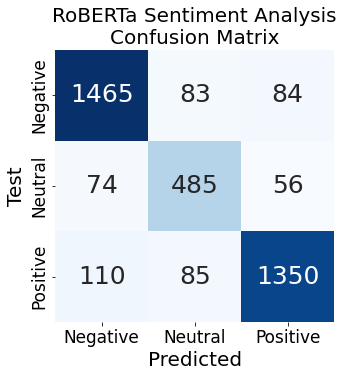

In [88]:
# confusion matrix
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [89]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.89      0.90      0.89      1632
     Neutral       0.74      0.79      0.76       615
    Positive       0.91      0.87      0.89      1545

   micro avg       0.87      0.87      0.87      3792
   macro avg       0.85      0.85      0.85      3792
weighted avg       0.87      0.87      0.87      3792
 samples avg       0.87      0.87      0.87      3792



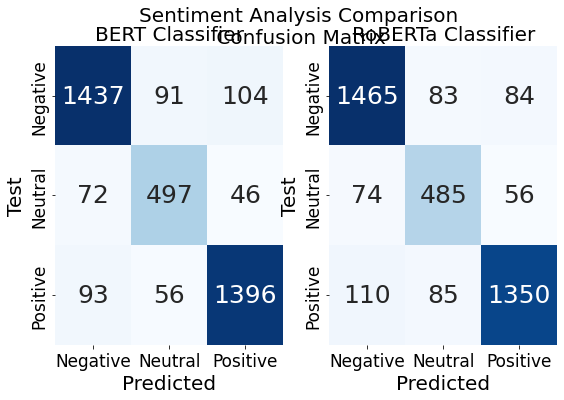

In [90]:
# classification matrix comparison
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()